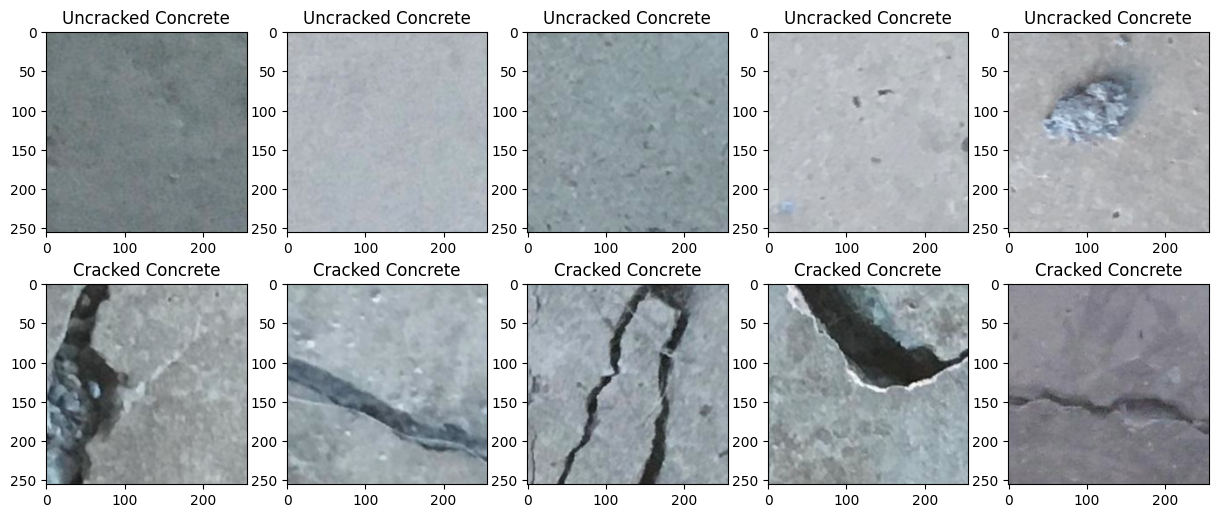

Compiling the model...
Model successfully compiled!!


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# loading and rotating for cracked
def load_images(folder, label):
    images = []
    for root, dirs, files in os.walk(folder): #Looking into the folder and all of its subfolders for images
        for filename in files:
            img = cv2.imread(os.path.join(root, filename))
            img = cv2.resize(img, (img_size, img_size))
            if img is not None:
                
                # Rotate the image by 90 degrees, 180 degrees, and 270 degrees
                img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                img_180 = cv2.rotate(img, cv2.ROTATE_180)
                img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                
                # Append all four images to the list
                images.append((img, label))
                images.append((img_90, label))
                images.append((img_180, label))
                images.append((img_270, label))
            
    return images

# load and rotate for uncracked
def load_images2(folder, label):
    images = []
    for root, dirs, files in os.walk(folder): #Looking into the folder and all of its subfolders for images
        for filename in files:
            img = cv2.imread(os.path.join(root, filename)) #Reading the image
            img = cv2.resize(img, (img_size, img_size)) #Maintaining the size of image
            if img is not None:
                
                # Rotate the image by  180 degrees, 
                img_180 = cv2.rotate(img, cv2.ROTATE_180)
                
                # Append images to the list
                images.append((img, label))
                images.append((img_180, label))
                
            
    return images


# dataset
cracked_folder = 'small dataset\\positive'
uncracked_folder = 'small dataset\\negative'


# image size
img_size = 256

# Load the images and labels from the folders
cracked_images = load_images(cracked_folder, 1) #Prprocess the crracked images and rotate them by 90, 180 and 270 degree
uncracked_images = load_images2(uncracked_folder, 0) #Only rotate by 180 degree for uncracked image


# Combine the images and labels and shuffle them
images = cracked_images + uncracked_images


# Split the data into training and testing sets by shuffling the order
train_images, test_images, train_labels, test_labels = train_test_split(
    [image[0] for image in images], [image[1] for image in images],
    test_size=0.2, random_state=42, shuffle=True)

# Convert the data to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Display some of the images from both classes
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

#fIVE PLOTS FOR EACH CLASS
for i in range(5):
    axs[i].imshow(train_images[train_labels==0][i]) #Label for 0
    axs[i].set_title('Uncracked Concrete')
    axs[i+5].imshow(train_images[train_labels==1][i]) #label for 1
    axs[i+5].set_title('Cracked Concrete')

plt.show() #Final plot


#Initialize the model
model = Sequential()

#First layer is a convolutional layer 
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3))) #16 filtyers of size 3X3 and relu AF
model.add(MaxPooling2D(pool_size = (2, 2))) #MaxPool
model.add(Dropout(.3)) #30% dropout

model.add(Conv2D(32, (3, 3), activation = "relu")) #Second layer is a convolutional 
model.add(MaxPooling2D(pool_size = (2, 2))) #MaxPool
model.add(Dropout(.3)) #Dropout

model.add(Conv2D(32, (3, 3), activation = "relu")) #THird layer is a convolutional 
model.add(MaxPooling2D(pool_size = (2, 2))) #MaxPool
model.add(Dropout(.3)) #Dropout

model.add(Flatten()) #Flatten as vector
model.add(Dense(258, activation = "relu")) #Fully connected layer with relu

model.add(Dense(1, activation = "sigmoid")) #Output probability layer with sigmoidal

print("Compiling the model...")
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) #Adaptive Moment Estimation, minimises loss and help model converge faster
print("Model successfully compiled!!")

In [2]:
#Fitting the model
print("Fitting the model...")
model.fit(train_images, train_labels, batch_size = 64, epochs = 8)
print("Model successfully fitted!!")

Fitting the model...
Epoch 1/8
225/225 [==============================] - 516s 2s/step - loss: 78.0257 - accuracy: 0.6091
Epoch 2/8
225/225 [==============================] - 519s 2s/step - loss: 0.3746 - accuracy: 0.8220
Epoch 3/8
225/225 [==============================] - 439s 2s/step - loss: 0.2601 - accuracy: 0.8871
Epoch 4/8
225/225 [==============================] - 431s 2s/step - loss: 0.2406 - accuracy: 0.9048
Epoch 5/8
225/225 [==============================] - 432s 2s/step - loss: 0.1947 - accuracy: 0.9263
Epoch 6/8
225/225 [==============================] - 431s 2s/step - loss: 0.1853 - accuracy: 0.9348
Epoch 7/8
225/225 [==============================] - 432s 2s/step - loss: 0.1612 - accuracy: 0.9440
Epoch 8/8
225/225 [==============================] - 439s 2s/step - loss: 0.1412 - accuracy: 0.9540
Model successfully fitted!!


In [5]:
#Testing the model with test data
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


#Plotting the ROC Curve

# Get the predicted probabilities for the test set
y_scores = model.predict(test_images)

# Compute the false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(test_labels, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#Looking at the confusion matrix


# Get predicted labels on the training set
train_pred = model.predict(train_images)

# Get predicted labels on the test set
test_pred = model.predict(test_images)

# Compute the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred.round())

# Compute the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred.round())

# Print the confusion matrices
print("Confusion matrix for training set:")
print(train_cm)
print("Confusion matrix for test set:")
print(test_cm)


# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix for the training set
plt.figure(figsize=(5,5))
plot_confusion_matrix(train_cm, classes=['Uncracked', 'Cracked'], title='Training Confusion Matrix')
plt.show()

# Plot the confusion matrix for the testing set
plt.figure(figsize=(5,5))
plot_confusion_matrix(test_cm, classes=['Uncracked', 'Cracked'], title='Testing Confusion Matrix')
plt.show()


# Set the path to the folder containing the test images
test_folder = 'C:\\Users\\Hp\\Downloads\\Cracks_Detection-main\\check'

# Load the test images and resize them to the same size used for training
test_images = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder,filename))
    img = cv2.resize(img, (img_size, img_size))
    test_images.append(img)

# Convert the test images to a NumPy array and normalize the pixel values
test_images = np.array(test_images) / 255.0

# Use the model to predict the class probabilities of the test images
predictions = model.predict(test_images)

# Print the predicted class probabilities
for i, pred in enumerate(predictions):
    print(f"Image {i+1}: {pred[0]}")
    



# Set the path to the folder containing the test images never seen by the model
test_folder = 'C:\\Users\\Hp\\Downloads\\Cracks_Detection-main\\check'

# Load the test images and resize them to the same size used for training
test_images = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder,filename))
    img = cv2.resize(img, (img_size, img_size))
    test_images.append(img)

# Convert the test images to a NumPy array and normalize the pixel values
test_images = np.array(test_images) 

# Use the model to predict the class probabilities of the test images
predictions = model.predict(test_images)


ValueError: Data cardinality is ambiguous:
  x sizes: 256, 256, 256, 256, 256, 256, 256, 256
  y sizes: 3600
Make sure all arrays contain the same number of samples.

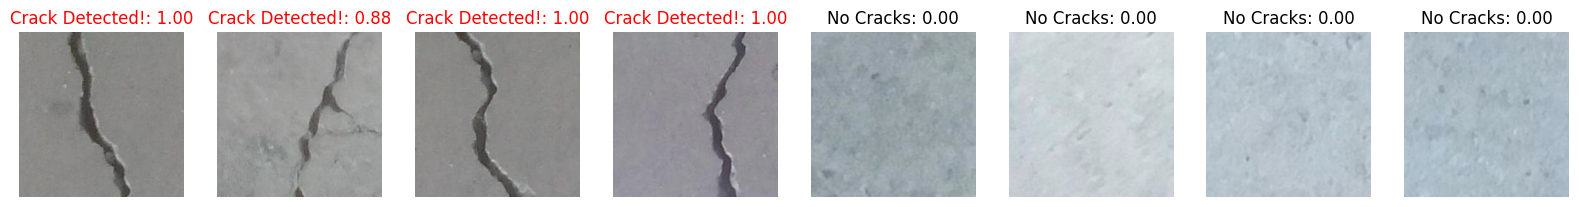

In [ ]:
# Show the test images and predicted class probabilities
fig, axs = plt.subplots(1, 8, figsize=(20, 10))
for i, (img, pred) in enumerate(zip(test_images, predictions)):
    axs[i].imshow(img)
    axs[i].axis('off')
    if pred[0] < 0.5:
        axs[i].set_title('No Cracks: {:.2f}'.format(pred[0]))
    else:
        axs[i].set_title('Crack Detected!: {:.2f}'.format(pred[0]), color='red')
plt.show()

In [ ]:
model.save('CrackDetectModel.h5')

C:\Users\Hp\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#algorithm

import cv2
import numpy as np

def detect_cracks(frame):

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Gray', gray)
   

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2.imshow('Blurred', blurred)
    

    edges = cv2.Canny(blurred, 130, 150)
    cv2.imshow('Edges', edges)
   

    # Perform adaptive thresholding
    thresh = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 4)

    # Perform morphological operations to fill gaps and holes
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop over the contours
    for contour in contours:
        # Get the area of the contour
        area = cv2.contourArea(contour)

        # Filter out small contours (noise)
        if area < 100:
            continue
        cv2.drawContours(frame, [contour], -1, (0, 255, 0), 2)

    # Display the detected cracks
    cv2.imshow('Cracks Detected', frame)
    

# IP Webcam URL from your phone's camera
video_url = 'http://192.168.1.18:8080/video'

# Initialize webcam using IP Webcam URL
cap = cv2.VideoCapture(video_url)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)

    # Detect cracks on the current frame
    detect_cracks(frame)

    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

# Function to detect cracks and measure length and width
def detect_cracks(frame):
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 130, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Loop over contours
    for contour in contours:
        # Fit an ellipse to the contour
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (x, y), (length, width), angle = ellipse
            
            # Filter out small contours (noise)
            area = cv2.contourArea(contour)
            if area < 100:
                continue
            
            # Draw ellipse around the crack
            cv2.ellipse(frame, ellipse, (0, 255, 0), 2)
            
            # Display length and width above the crack
            cv2.putText(frame, f'Length: {int(length)} px, Width: {int(width)} px', (int(x + length / 2), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return frame

# Access the video feed from your phone's camera using IP Webcam
video_url = 'http://192.168.1.18:8080/video'  # Replace with your phone's IP address
cap = cv2.VideoCapture(video_url)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detect cracks and measure length and width
    processed_frame = detect_cracks(frame)
    
    # Display the frame
    cv2.imshow('Crack Detection', processed_frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

model = load_model('divyansh_1.h5') 

def preprocess_frame(frame):
    processed_frame = cv2.resize(frame, (256, 256))  # adjusted resize
    processed_frame = processed_frame / 255.0  # normalization
    return processed_frame

def detect_cracks_using_model(frame):
    processed_frame = preprocess_frame(frame)
    predictions = model.predict(np.array([processed_frame]))
    
    if predictions[0] > 0.5:
        print("Crack Detected!")
        return True
    else:
        print("No cracks detected yet.")
        return False

video_url = 'http://192.168.1.18:8080/video'
cap = cv2.VideoCapture(video_url)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Apply crack detection on the current frame
    has_crack = detect_cracks_using_model(frame)
    if has_crack:
        detect_cracks(frame)
    # Display the frame
    cv2.imshow('Crack Detection', frame)
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 108ms/step
Crack Detected!
1/1 [==============================] - 0s 48ms/step
Crack Detected!
1/1 [==============================] - 0s 36ms/step
Crack Detected!
1/1 [==============================] - 0s 36ms/step
Crack Detected!
1/1 [==============================] - 0s 36ms/step
Crack Detected!
1/1 [==============================] - 0s 37ms/step
Crack Detected!
1/1 [==============================] - 0s 37ms/step
Crack Detected!
1/1 [==============================] - 0s 34ms/step
Crack Detected!
1/1 [==============================] - 0s 36ms/step
Crack Detected!
1/1 [==============================] - 0s 36ms/step
Crack Detected!
1/1 [==============================] - 0s 35ms/step
Crack Detected!
1/1 [==============================] - 0s 34ms/step
Crack Detected!
1/1 [==============================] - 0s 35ms/step
Crack Detected!
1/1 [==============================] - 0s 37ms/step
Crack Detected!
1/1 [==============================] - 0s 37ms/